# 인물 모드 문제점 찾기

## 개요
하나의 카메라로 Shallow Focus, Chroma key 등을 만들고 문제점과 개선방안을 찾아나가는 프로젝트입니다.  
먼저 이미지 세그멘테이션(image segmentation) 기술을 이용하여 하나의 이미지에서 배경과 사람을 분리합니다.  
분리된 이미지를 활용하여 아웃포커싱 효과와 다른 배경(Chroma key)을 적용해보겠습니다.  

## 목차
1. 인물모드 직접 해보기 : 인물 사진과 고양이 사진 아웃포커싱
2. 인물모드 직접 해보기 : 크로마키 배경 합성
3. 사진에서 문제점 찾기
4. 해결 방법을 제안해 보기

## 회고

# Reference

---

### 주요 라이브러리 버전 확인하기

In [1]:
# importlib: 사용자가 파이썬의 import 시스템과 상호작용하기 위한 API를 제공하는 내장 라이브러리
# 사용자는 import 함수의 구현 내용과, 실행에 필요한 하위 함수들을 이용해 필요에 맞는 임포터를 직접 구현하거나 임포트 관련 기능들을 자유롭게 사용할 수 있음
# importlib.metadata: 설치된 패키지 메타 데이터에 대한 접근을 제공하는 라이브러리.
# 해당 코드 블럭에서는 importlib.metadata 안에 있는 version() 함수를 이용하여 pixellib 라이브러리의 버전을 확인

from importlib.metadata import version
import cv2
import pixellib

print(cv2.__version__)
print(version('pixellib'))

4.5.3
0.7.1


## 1. 인물모드 직접 해보기 : 인물모드 사진과 고양이 아웃포커싱 사진 만들기
- 여러분의 셀카를 이용해서 오늘 배운 내용을 수행해 봅시다. 아래와 같은 이미지를 얻어야 합니다. 최소 3장 이상의 인물모드 사진을 만들어 봅시다.
- 인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있을 것입니다. 시맨틱 세그멘테이션 스텝에서 힌트를 찾아봅시다.
- 배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경 합성을 시도해 볼 수도 있을 것입니다. 여러분만의 환상적인 사진을 만들어 보면 어떨까요?

In [2]:
import os
import urllib
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

(662, 540, 3)
(804, 1000, 3)
(1350, 1080, 3)
(1008, 1500, 3)


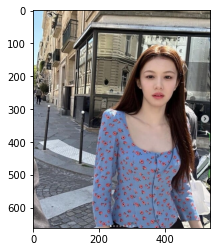

None


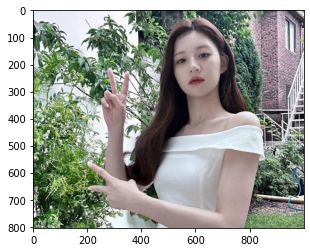

None


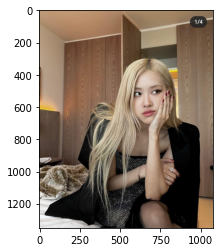

None


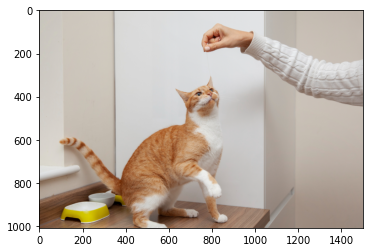

None


In [3]:
# 이미지 읽어오기
img01_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/kyj.jpeg'  
img01_orig = cv2.imread(img01_path) 
img02_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/kyj02.jpeg'  
img02_orig = cv2.imread(img02_path) 
img03_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/rosy.jpeg'  
img03_orig = cv2.imread(img03_path) 
img04_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpg'  
img04_orig = cv2.imread(img04_path) 

print(img01_orig.shape)
print(img02_orig.shape)
print(img03_orig.shape)
print(img04_orig.shape)

plt.imshow(cv2.cvtColor(img01_orig, cv2.COLOR_BGR2RGB))
print(plt.show())
plt.imshow(cv2.cvtColor(img02_orig, cv2.COLOR_BGR2RGB))
print(plt.show())
plt.imshow(cv2.cvtColor(img03_orig, cv2.COLOR_BGR2RGB))
print(plt.show())
plt.imshow(cv2.cvtColor(img04_orig, cv2.COLOR_BGR2RGB))
print(plt.show())

### PixelLib에서 제공해주는 모델을 다운로드하기

In [4]:
# 디렉토리 설정 및 모델 파일 다운로드
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 모델 다운로드
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f767a70cf40>)

### 다운로드한 모델을 이용해 PixelLib로 내가 사용할 세그멘테이션 모델을 생성

In [5]:
# semantic segmentation을 수행하는 클래스 인스턴스를 만들기
model = semantic_segmentation() 

# pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출
model.load_pascalvoc_model(model_file) 

### 모델에 이미지 입력하고 이미지 확인

In [6]:
segvalues01, output01 = model.segmentAsPascalvoc(img01_path)
segvalues02, output02 = model.segmentAsPascalvoc(img02_path)
segvalues03, output03 = model.segmentAsPascalvoc(img03_path)
segvalues04, output04 = model.segmentAsPascalvoc(img04_path)

In [7]:
#pascalvoc 데이터의 라벨 종류 확인
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

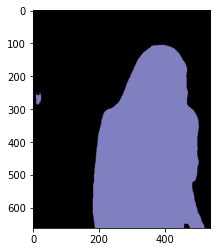

None


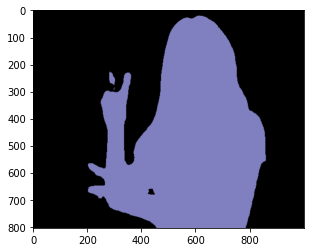

None


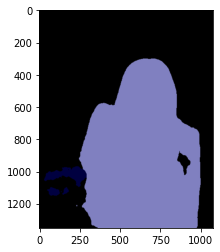

None


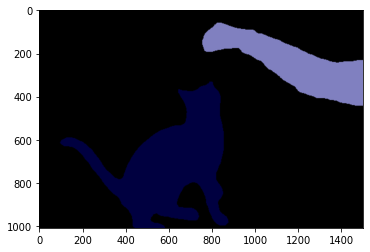

None


In [8]:
# output 확인
plt.imshow(output01)
print(plt.show())
plt.imshow(output02)
print(plt.show())
plt.imshow(output03)
print(plt.show())
plt.imshow(output04)
print(plt.show())

In [9]:
# segvalues 확인
print(segvalues01)
print(segvalues02)
print(segvalues03)
print(segvalues04)

{'class_ids': array([ 0, 15]), 'masks': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])}
{'class_ids': array([ 0, 15]), 'masks': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])}
{'class_ids': array([ 0,  8, 15]), 'masks': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       .

In [10]:
# label 출력

for class_id in segvalues01['class_ids']:
    print(LABEL_NAMES[class_id])
    
for class_id in segvalues02['class_ids']:
    print(LABEL_NAMES[class_id])
    
for class_id in segvalues03['class_ids']:
    print(LABEL_NAMES[class_id])
    
for class_id in segvalues04['class_ids']:
    print(LABEL_NAMES[class_id])

background
person
background
person
background
cat
person
background
cat
person


### 컬러맵 만들기
컬러맵을 활용하여 물체마다 output에 어떤 색상으로 나타나 있는지 알아냅니다.

In [11]:
#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [12]:
#컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람, 8번째인 고양이)

print(colormap[15])   # 사람
print(colormap[8])   # 고양이

[192 128 128]
[64  0  0]


### 색상(채널) 순서 바꿔주기

In [13]:
# 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서
seg_color = (128,128,192)   # 사람
seg_color_cat = (0,0,64)   # 고양이

### 사람(seg_color)으로만 이루어진 마스크 만들기

(662, 540)


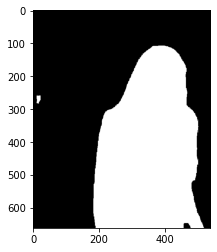

(804, 1000)


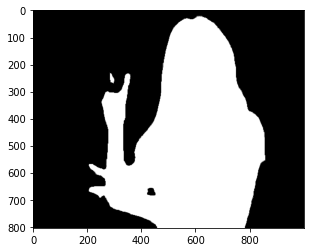

(1350, 1080)


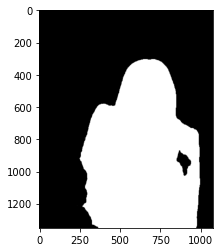

In [14]:
# seg_color로만 이루어진 마스크를 만들어보기

seg_map01 = np.all(output01==seg_color, axis=-1) 
print(seg_map01.shape) 
plt.imshow(seg_map01, cmap='gray')
plt.show()

seg_map02 = np.all(output02==seg_color, axis=-1) 
print(seg_map02.shape) 
plt.imshow(seg_map02, cmap='gray')
plt.show()

seg_map03 = np.all(output03==seg_color, axis=-1) 
print(seg_map03.shape) 
plt.imshow(seg_map03, cmap='gray')
plt.show()


# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다.
# seg_color 값이 person 값이므로 사람이 있는 위치를 제외하고는 gray로 출력
# cmap 값을 변경하면 다른 색상으로 확인이 가능함

# seg_map = np.all(output == seg_color, axis=-1)를 사용하여 세그멘테이션 결과에서 지정된 색상과 일치하는 픽셀을 찾아 seg_map에 저장
# axis=-1는 NumPy 배열에서 연산을 수행할 때, 마지막 축을 기준으로 연산을 진행하라는 의미.

### 고양이로만 만들어진 마스크 만들기

(1008, 1500)


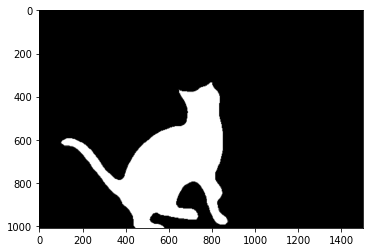

In [15]:
# seg_color로만 이루어진 마스크를 만들어보기

seg_map04 = np.all(output04==seg_color_cat, axis=-1) 
print(seg_map04.shape) 
plt.imshow(seg_map04, cmap='gray')
plt.show()

- output 배열은 이미지의 세그멘테이션 결과를 나타냅니다. 이 코드에서는 특정 색상인 seg_color와 일치하는 픽셀을 찾기 위해 np.all 함수를 사용합니다.
- axis=-1는 마지막 차원(여기서는 채널)을 기준으로 모든 조건을 만족해야 하는지를 나타내며, 이를 통해 RGB 색상에 대한 일치 여부를 확인합니다.
- 결과로 생성된 seg_map은 불리언 형태의 배열로, True는 해당 픽셀이 seg_color와 일치함을 나타냅니다.  

이제 아래처럼 물체가 있는 위치는 1(True), 그 외에는 0(Flase)인 배열이 되었습니다.

In [16]:
# [
# [ 0 1 1 0 0 0 1 1 0 ],
# [ 1 1 1 1 0 1 1 1 1 ],
# [ 0 1 1 1 1 1 1 1 0 ],
# [ 0 0 1 1 1 1 1 0 0 ],
# [ 0 0 0 1 1 1 0 0 0 ]
# ]

### 세그멘테이션이 얼마나 잘 되었는지 확인하기
사람과 배경을 분리해서 표현한 color_mask를 만들어 원본 이미지 위에 color_mask를 합쳐서 출력합니다.

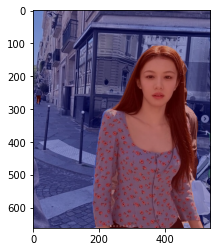

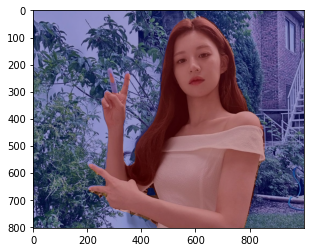

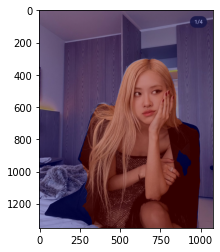

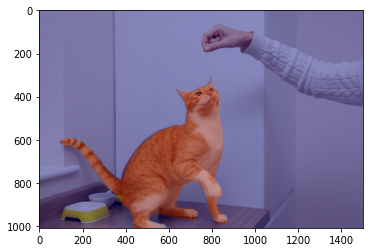

In [17]:
# 원본 이미지를 img_show에 할당한 뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든 뒤 두 이미지를 합쳐서 출력

# 원본 이미지를 img_show에 할당
img_show01 = img01_orig.copy()
img_show02 = img02_orig.copy()
img_show03 = img03_orig.copy()
img_show04 = img04_orig.copy()

# True(1)과 False(0)인 값을 각각 255과 0으로 바꿔줍니다. -> 대상(사람, 고양이)은 255, 그 외는 0이 됩니다.
img_mask01 = seg_map01.astype(np.uint8) * 255
img_mask02 = seg_map02.astype(np.uint8) * 255
img_mask03 = seg_map03.astype(np.uint8) * 255
img_mask04 = seg_map04.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask01 = cv2.applyColorMap(img_mask01, cv2.COLORMAP_JET)
color_mask02 = cv2.applyColorMap(img_mask02, cv2.COLORMAP_JET)
color_mask03 = cv2.applyColorMap(img_mask03, cv2.COLORMAP_JET)
color_mask04 = cv2.applyColorMap(img_mask04, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show01 = cv2.addWeighted(img_show01, 0.6, color_mask01, 0.4, 0.0)
img_show02 = cv2.addWeighted(img_show02, 0.6, color_mask02, 0.4, 0.0)
img_show03 = cv2.addWeighted(img_show03, 0.6, color_mask03, 0.4, 0.0)
img_show04 = cv2.addWeighted(img_show04, 0.6, color_mask04, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show01, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(img_show02, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(img_show03, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(img_show04, cv2.COLOR_BGR2RGB))
plt.show()

### blur() 함수를 이용하여 배경을 흐리게 만들기
1. 원본 사진 전체를 흐리게 만들기(블러 처리)
2. 블러 처리된 사진에서 (블러)배경만 추출하기

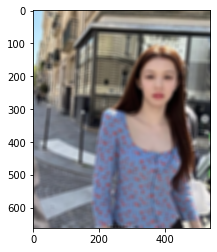

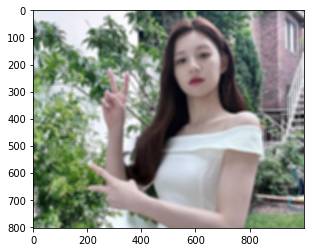

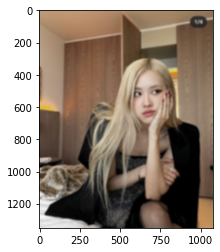

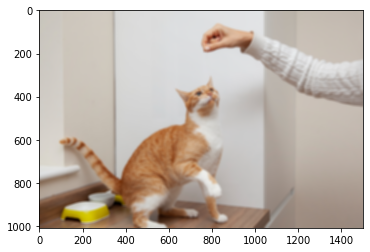

In [18]:
# 원본 사진 전체를 흐리게 만들기
img_orig_blur01 = cv2.blur(img01_orig, (13,13))
img_orig_blur02 = cv2.blur(img02_orig, (13,13))
img_orig_blur03 = cv2.blur(img03_orig, (13,13))
img_orig_blur04 = cv2.blur(img04_orig, (13,13))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)   
plt.imshow(cv2.cvtColor(img_orig_blur01, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(img_orig_blur02, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(img_orig_blur03, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(img_orig_blur04, cv2.COLOR_BGR2RGB))
plt.show()

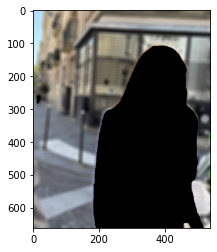

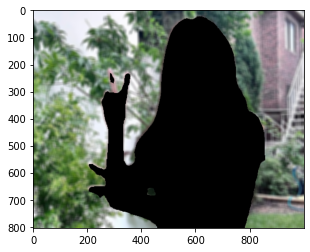

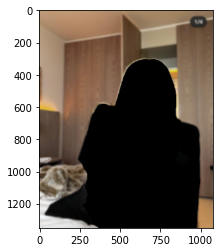

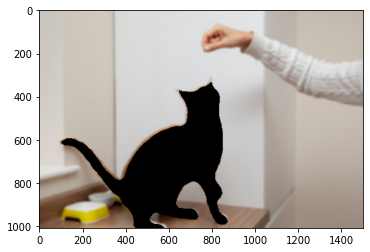

In [19]:
# 블러 배경만 추출하기 - 흐려진 이미지에서 세그멘테이션 마스크를 이용하여!

# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 RGB 형식으로 변경 (원본이 BGR 형식이므로)
img_mask_color01 = cv2.cvtColor(img_mask01, cv2.COLOR_GRAY2BGR)
img_mask_color02 = cv2.cvtColor(img_mask02, cv2.COLOR_GRAY2BGR)
img_mask_color03 = cv2.cvtColor(img_mask03, cv2.COLOR_GRAY2BGR)
img_mask_color04 = cv2.cvtColor(img_mask04, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 대상(사람, 고양이)이 255 였으나, 연산을 하고 나면 배경은 255 대상은 0입니다.
img_bg_mask01 = cv2.bitwise_not(img_mask_color01)
img_bg_mask02 = cv2.bitwise_not(img_mask_color02)
img_bg_mask03 = cv2.bitwise_not(img_mask_color03)
img_bg_mask04 = cv2.bitwise_not(img_mask_color04)

# 블러 배경만 얻기
img_bg_blur01 = cv2.bitwise_and(img_orig_blur01, img_bg_mask01)
plt.imshow(cv2.cvtColor(img_bg_blur01, cv2.COLOR_BGR2RGB))
plt.show()
img_bg_blur02 = cv2.bitwise_and(img_orig_blur02, img_bg_mask02)
plt.imshow(cv2.cvtColor(img_bg_blur02, cv2.COLOR_BGR2RGB))
plt.show()
img_bg_blur03 = cv2.bitwise_and(img_orig_blur03, img_bg_mask03)
plt.imshow(cv2.cvtColor(img_bg_blur03, cv2.COLOR_BGR2RGB))
plt.show()

img_bg_blur04 = cv2.bitwise_and(img_orig_blur04, img_bg_mask04)
plt.imshow(cv2.cvtColor(img_bg_blur04, cv2.COLOR_BGR2RGB))
plt.show()

# cv2.bitwise_and()을 활용하여 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 
# 결국 사람이 사라지고 배경만 남습니다!

### 흐린(블러)배경과 원본 사진 합성(합치기)

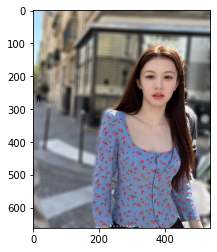

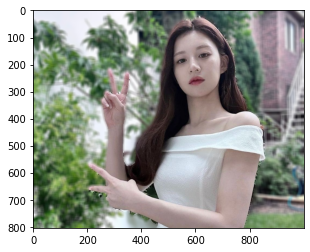

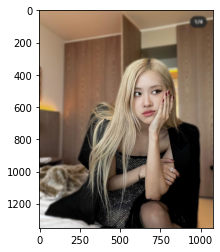

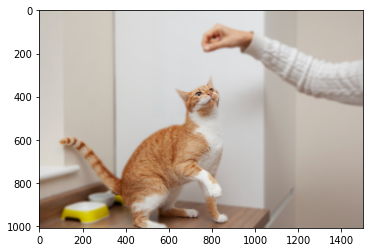

In [20]:
# 블러 배경과 원본 이미지의 대상 합치기
img_concat01 = np.where(img_mask_color01==255, img01_orig, img_bg_blur01)   # 사람
img_concat02 = np.where(img_mask_color02==255, img02_orig, img_bg_blur02)   # 사람
img_concat03 = np.where(img_mask_color03==255, img03_orig, img_bg_blur03)   # 사람
img_concat04 = np.where(img_mask_color04==255, img04_orig, img_bg_blur04)   # 고양이
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 (원본 이미지에서는 사람 또는 고양이가 255)
# 아닌 영역은 블러된 이미지 값을 사용합니다.

plt.imshow(cv2.cvtColor(img_concat01, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(img_concat02, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(img_concat03, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(img_concat04, cv2.COLOR_BGR2RGB))
plt.show()
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)

## 2. 인물모드 직접 해보기 : 크로마키 배경 합성

인물 사진의 배경과 고양이 사진을 합성해보겠습니다.

### 이미지 읽어오고 확인하기

(804, 1000, 3)
(1008, 1500, 3)


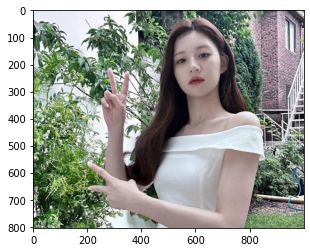

None


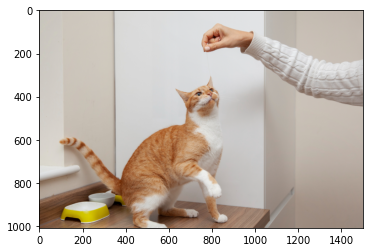

None


In [56]:
# 이미지 읽어오기
img02_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/kyj02.jpeg'  
img02_orig = cv2.imread(img02_path)  # 인물 사진
img04_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpg'  
img04_orig = cv2.imread(img04_path)  # 고양이 사진

print(img02_orig.shape)
print(img04_orig.shape)

plt.imshow(cv2.cvtColor(img02_orig, cv2.COLOR_BGR2RGB))
print(plt.show())
plt.imshow(cv2.cvtColor(img04_orig, cv2.COLOR_BGR2RGB))
print(plt.show())

In [57]:
# Resize : 고양이 사진을 인물 사진의 사이즈에 맞게 조정하기
img04_orig = cv2.resize(img04_orig, (1000, 804))

print(img02_orig.shape)
print(img04_orig.shape)

(804, 1000, 3)
(804, 1000, 3)


(1008, 1500)


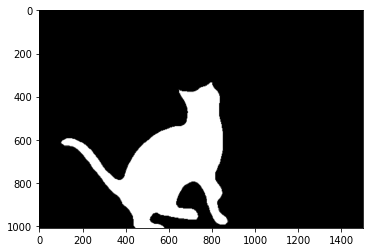

In [58]:
# 고양이(seg_color)로만 이루어진 마스크를 만들어보기

seg_map04 = np.all(output04==seg_color_cat, axis=-1) 
print(seg_map04.shape) 
plt.imshow(seg_map04, cmap='gray')
plt.show()

In [45]:
# 원본 이미지를 img_show에 할당한 뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든 뒤 두 이미지를 합쳐서 출력

# 원본 이미지를 img_show에 할당
img_show04 = img04_orig.copy()

# True(1)과 False(0)인 값을 각각 255과 0으로 바꿔줍니다. -> 대상(고양이)은 255, 그 외는 0이 됩니다.
img_mask04 = seg_map04.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask04 = cv2.applyColorMap(img_mask04, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show04 = cv2.addWeighted(img_show04, 0.6, color_mask04, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show04, cv2.COLOR_BGR2RGB))
plt.show()

error: OpenCV(4.5.3) /tmp/pip-req-build-agffqapq/opencv/modules/core/src/arithm.cpp:647: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'arithm_op'


인풋의 사이즈가 맞지 않는다는 오류가 발생.
마스크의 사이즈도 원본 이미지와 동일하게 조정하였습니다.

In [59]:
# 마스크 사이즈 조정
color_mask04 = cv2.resize(color_mask04, (1000, 804))

In [60]:
print(color_mask04.shape)
print(img_show04.shape)

(804, 1000, 3)
(804, 1000, 3)


여전히 사이즈가 달라 다시 조정합니다.

In [61]:
# color_mask04를 img_show04와 동일한 크기로 조정
color_mask04 = cv2.resize(color_mask04, (img_show04.shape[1], img_show04.shape[0]))

print(color_mask04.shape)
print(img_show04.shape)

(804, 1000, 3)
(804, 1000, 3)


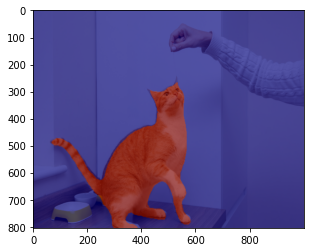

In [62]:
# 원본 이미지와 마스크를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show04 = cv2.addWeighted(img_show04, 0.6, color_mask04, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show04, cv2.COLOR_BGR2RGB))
plt.show()

사이즈 조정이 잘 되어 color mask를 활용한 세그멘테이션 여부가 성공적으로 확인되었습니다.

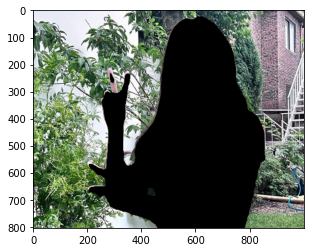

In [29]:
# 인물 사진의 배경만 추출하기 - 인물 이미지에서 세그멘테이션 마스크를 이용하여!

# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 RGB 형식으로 변경 (원본이 BGR 형식이므로)
img_mask_color02 = cv2.cvtColor(img_mask02, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 대상(사람)이 255 였으나, 연산을 하고 나면 배경은 255 대상은 0입니다.
img_bg_mask02 = cv2.bitwise_not(img_mask_color02)


# 인물사진의 배경만 얻기
img_bg_02 = cv2.bitwise_and(img02_orig, img_bg_mask02)
plt.imshow(cv2.cvtColor(img_bg_02, cv2.COLOR_BGR2RGB))
plt.show()

# cv2.bitwise_and()을 활용하여 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 
# 결국 사람이 사라지고 배경만 남습니다!

### 추출한 배경과 고양이 이미지 합성하기

In [30]:
# 추출한 배경과 원본 이미지의 대상 합치기
img_concat04 = np.where(img_mask_color04==255, img_bg_02, img_bg_mask02)   # 고양이
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 (원본 이미지에서는 고양이가 255)
# 아닌 영역은 블러된 이미지 값을 사용합니다.

plt.imshow(cv2.cvtColor(img_concat04, cv2.COLOR_BGR2RGB))
plt.show()
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)

ValueError: operands could not be broadcast together with shapes (1008,1500,3) (804,1000,3) (804,1000,3) 

- 사이즈가 맞지 않는 오류가 발생하여 재조정합니다.

In [31]:
img_mask_color04.shape

(1008, 1500, 3)

In [32]:
img_mask_color04 = cv2.resize(img_mask_color04, (img_show04.shape[1], img_show04.shape[0]))

img_mask_color04.shape

(804, 1000, 3)

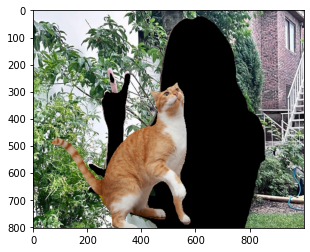

In [33]:
# 추출한 배경과 원본 이미지의 대상 합치기
img_concat04 = np.where(img_mask_color04==255, img04_orig, img_bg_02)   # 고양이
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 (원본 이미지에서는 고양이가 255)
# 아닌 영역은 블러된 이미지 값을 사용합니다.

plt.imshow(cv2.cvtColor(img_concat04, cv2.COLOR_BGR2RGB))
plt.show()
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)

고양이 사진의 배경을 바꾸었지만 배경 이미지의 대상이 있던 영역이 비어있어 자연스럽지 않은 합성 결과가 나왔습니다.  
다른 크로마키 합성 방법이 있을지 찾아보고 활용해보겠습니다.

---
### 크로마키 2차 시도

방법1 : 초록색(192) 만 있는 이미지를 만들고, 따온 대상을 그 위에 붙이기   
방법2 : 라벨에 포함되지 않을 이미지에 따온 대상을 concate

(1000, 1500, 3)


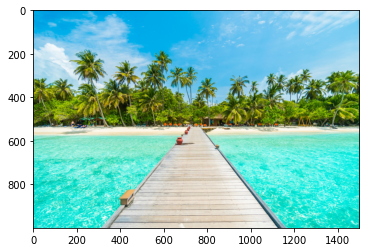

None


In [63]:
import cv2
import os
import urllib
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt
import matplotlib.pylab as plt

# 크로마키 영상과 합성할 영상 읽기
back_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/vacation.jpg'  
back_img_orig = cv2.imread(back_img_path)   # 배경 사진

print(back_img_orig.shape)

plt.imshow(cv2.cvtColor(back_img_orig, cv2.COLOR_BGR2RGB))
print(plt.show())

In [72]:
# 모델에 이미지 입력하기
segvalues, output = model.segmentAsPascalvoc(back_img_path) 
# segmentAsPascalvoc()함수를 호출하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 분할은 pacalvoc 데이터로 학습된 모델을 이용

In [73]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

배경이미지는 모델에 해당하는 라벨이 없는 이미지입니다. 이 배경 이미지에 고양이 이미지를 concate 하겠습니다.

(1008, 1500)


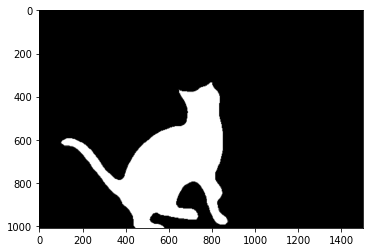

In [68]:
# 고양이(seg_color)로만 이루어진 마스크를 만들어보기

seg_map04 = np.all(output04==seg_color_cat, axis=-1) 
print(seg_map04.shape) 
plt.imshow(seg_map04, cmap='gray')
plt.show()

In [75]:
# 추출한 배경과 원본 이미지의 대상 합치기
img_concat04 = np.where(img_mask_color04==255, img04_orig, back_img_orig)   # 고양이
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 (원본 이미지에서는 고양이가 255)
# 아닌 영역은 블러된 이미지 값을 사용합니다.

plt.imshow(cv2.cvtColor(img_concat04, cv2.COLOR_BGR2RGB))
plt.show()
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)

ValueError: operands could not be broadcast together with shapes (1008,1500,3) (804,1000,3) (1000,1500,3) 

- shape이 맞지 않다는 오류가 발생하여 shape을 맞춰줍니다.

In [78]:
print(img_concat04.shape)
print(img04_orig.shape)
print(back_img_orig.shape)

(804, 1000, 3)
(804, 1000, 3)
(1000, 1500, 3)


In [79]:
back_img_orig = cv2.resize(back_img_orig, (img_show04.shape[1], img_show04.shape[0]))

back_img_orig.shape

(804, 1000, 3)

In [81]:
img_mask_color04 = cv2.resize(img_mask_color04, (img_show04.shape[1], img_show04.shape[0]))

img_mask_color04.shape

(804, 1000, 3)

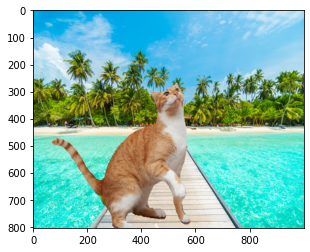

In [82]:
# 추출한 배경과 원본 이미지의 대상 합치기
img_concat04 = np.where(img_mask_color04==255, img04_orig, back_img_orig)   # 고양이
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 (원본 이미지에서는 고양이가 255)
# 아닌 영역은 블러된 이미지 값을 사용합니다.

plt.imshow(cv2.cvtColor(img_concat04, cv2.COLOR_BGR2RGB))
plt.show()
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)

---
아래는 크로마키 만들기 과정에서의 오류로 **3. 사진에서 문제점 찾기** 전까지의 내용은 무시해주세요.

In [1]:
import cv2
import os
import urllib
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt
import matplotlib.pylab as plt

# 크로마키 영상과 합성할 영상 읽기
img_path00 = os.getenv('HOME')+'/aiffel/human_segmentation/images/actress_chromakey.jpg'  
img_orig00 = cv2.imread(img_path00)   # 배우 크로마키 사진
img_path_vacation = os.getenv('HOME')+'/aiffel/human_segmentation/images/vacation.jpg'  
img_orig_vacation = cv2.imread(img_path_vacation)   # 휴양지 사진

print(img_orig00.shape)
print(img_orig_vacation.shape)

(470, 400, 3)
(1000, 1500, 3)


In [ ]:
# ROI 선택을 위한 좌표 계산 (가운데에 위치하기 위한)

height1, width1 = img_orig00.shape[:2]
height2, width2 = img_orig_vacation.shape[:2]

x = (width2 - width1) // 2
y = height2 - height1
w = x + width1
h = y + height1


# 크로마키 배경 영상에서 크로마키가 있을 법한 영역을 10픽셀 정도로 지정
chromakey = img_orig00[:10, :10, :] # (0,0)~(10,10)까지의 정사각형 좌표
offset = 20 # 임의의 값


# 크로마키 영역과 영상 전체를 HSV로 변경
hsv_chroma = cv2.cvtColor(chromakey, cv2.COLOR_BGR2HSV)
hsv_img = cv2.cvtColor(img_orig00, cv2.COLOR_BGR2HSV)

 

# 크로마키 영역의 H 값에서 offset 만큼 여유를 두어 범위 지정
chroma_h = hsv_chroma[:, :, 0] # 크로마키의 H 값 (초록색 또는 파란색)
lower = np.array([chroma_h.min()-offset, 100, 100]) # 크로마키의 최소 범위
upper = np.array([chroma_h.max()+offset, 255, 255]) # 크로마키의 최대 범위

 
# 마스크 생성 및 마스킹 후 합성
mask = cv2.inRange(hsv_img, lower, upper)   # 사람은 픽셀 0 (검정색)
mask_inv = cv2.bitwise_not(mask)            # 배경은 픽셀 0 (검정색) mask의 반
roi = img_orig_vacation[y:h, x:w]                        # 배경에서의 관심영역 (가운데)
fg = cv2.bitwise_and(img_orig00, img_orig00, mask=mask_inv) # 사람만 떼내기
bg = cv2.bitwise_and(roi, roi, mask=mask)       # 배경만 떼내기

img_orig_vacation[y:h, x:w] = fg + bg                        # 사람만 + 배경만 (합성)

 

# 결과 출력
cv2.imshow('chromakey', img_orig00)
cv2.imshow('fg', fg)
cv2.imshow('bg', bg)
cv2.imshow('added', img_orig_vacation)

In [ ]:
plt.imshow(cv2.cvtColor(img01_orig, cv2.COLOR_BGR2RGB))
print(plt.show())

In [ ]:
# 준비한 이미지 읽기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/chromakey.jpg'  
img_orig = cv2.imread(img_path)   # 크로마키 사진

print(img_orig.shape)

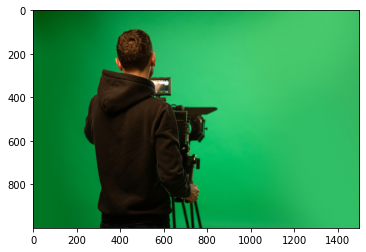

In [26]:
# 이미지 사본 만들기
img_orig_copy = np.copy(img_orig)

# BGR에서 RGB로 변경
img_orig_copy = cv2.cvtColor(img_orig_copy, cv2.COLOR_BGR2RGB)

# 이미지 확인하기
plt.imshow(img_orig_copy)

### Color Threshold 정의하기

In [27]:
lower_green = np.array([0, 0, 100])    
upper_green = np.array([120, 100, 255])

### Mask 만들기

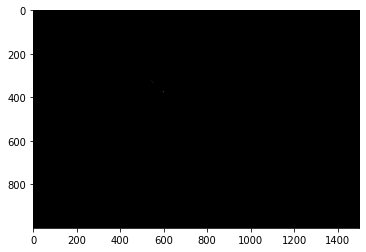

In [28]:
# Define the masked area
mask = cv2.inRange(img_orig_copy, lower_green, upper_green)

# Vizualize the mask
plt.imshow(mask,'gray')

마스크가 제대로 생성되지 않아 한계점을 조정하겠습니다.

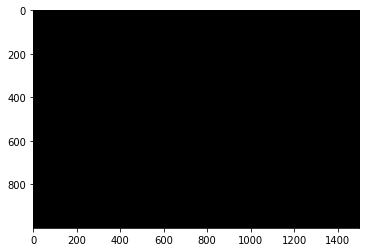

In [29]:
lower_green = np.array([0, 0, 230])    
upper_green = np.array([30, 30, 255])

# Define the masked area
mask = cv2.inRange(img_orig_copy, lower_green, upper_green)

# Vizualize the mask
plt.imshow(mask,'gray')

숫자를 다양하게 변경해보았지만 마스크가 생성되지 않아 다른 코드를 활용하겠습니다.

In [30]:
# 적절한 색상 범위 찾기
sample_color = img_orig_copy[100, 100]  # 예시로 이미지의 한 점의 색상을 샘플링
print("Sample Color (BGR):", sample_color)

Sample Color (BGR): [  0 102  26]


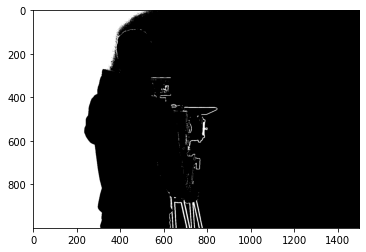

In [31]:
# 찾은 색상을 기반으로 lower_green 및 upper_green 설정
lower_green = np.array([max(0, sample_color[0] - 50), max(0, sample_color[1] - 50), max(0, sample_color[2] - 50)])
upper_green = np.array([min(255, sample_color[0] + 50), min(255, sample_color[1] + 50), min(255, sample_color[2] + 50)])

# Define the masked area
mask = cv2.inRange(img_orig_copy, lower_green, upper_green)

# Visualize the mask
plt.imshow(mask, 'gray')
plt.show()

여전히 대상만 추출하는 마스크가 잘 만들어지지 않아 수치를 조정하겠습니다.

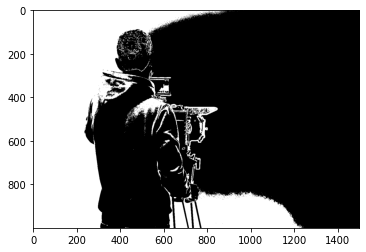

In [32]:
lower_green = np.array([max(0, sample_color[0] - 70), max(0, sample_color[1] - 70), max(0, sample_color[2] - 70)])
upper_green = np.array([min(255, sample_color[0] + 70), min(255, sample_color[1] + 70), min(255, sample_color[2] + 70)])

# Define the masked area
mask = cv2.inRange(img_orig_copy, lower_green, upper_green)

# Visualize the mask
plt.imshow(mask, 'gray')
plt.show()

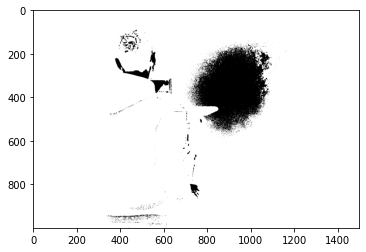

In [33]:
lower_green = np.array([max(0, sample_color[0] - 100), max(0, sample_color[1] - 100), max(0, sample_color[2] - 100)])
upper_green = np.array([min(255, sample_color[0] + 100), min(255, sample_color[1] + 100), min(255, sample_color[2] + 100)])

# Define the masked area
mask = cv2.inRange(img_orig_copy, lower_green, upper_green)

# Visualize the mask
plt.imshow(mask, 'gray')
plt.show()

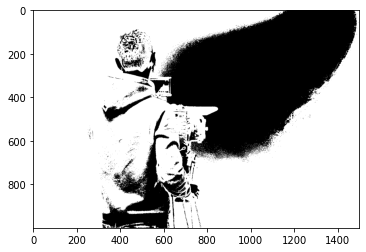

In [34]:
lower_green = np.array([max(0, sample_color[0] - 90), max(0, sample_color[1] - 90), max(0, sample_color[2] - 90)])
upper_green = np.array([min(255, sample_color[0] + 90), min(255, sample_color[1] + 90), min(255, sample_color[2] + 90)])

# Define the masked area
mask = cv2.inRange(img_orig_copy, lower_green, upper_green)

# Visualize the mask
plt.imshow(mask, 'gray')
plt.show()

In [35]:
# 적절한 색상 범위 찾기
sample_color = img_orig_copy[150, 150]  # 예시로 이미지의 한 점의 색상을 샘플링
print("Sample Color (BGR):", sample_color)

Sample Color (BGR): [  0 116  38]


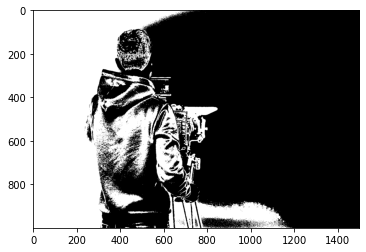

In [36]:
# 찾은 색상을 기반으로 lower_green 및 upper_green 설정
lower_green = np.array([max(0, sample_color[0] - 100), max(0, sample_color[1] - 100), max(0, sample_color[2] - 50)])
upper_green = np.array([min(255, sample_color[0] + 50), min(255, sample_color[1] + 50), min(255, sample_color[2] + 220)])

# Define the masked area
mask = cv2.inRange(img_orig_copy, lower_green, upper_green)

# Visualize the mask
plt.imshow(mask, 'gray')
plt.show()

HSV 색 공간을 사용해보기  
위의 시도들로 보아 색상 별 구분이 되지 않는 듯하여 cv2.inRange 함수에서 HSV 색 공간을 사용하여 마스킹을 수행해보겠습니다.  
이를 통해 색상, 채도 및 명도를 고려할 수 있습니다.

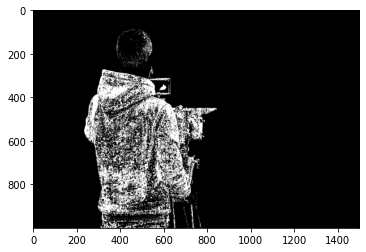

In [37]:
hsv = cv2.cvtColor(img_orig_copy, cv2.COLOR_RGB2HSV)
lower_green = np.array([max(0, sample_color[0] - 50), max(0, sample_color[1] - 50), max(0, sample_color[2] - 50)])
upper_green = np.array([min(255, sample_color[0] + 50), min(255, sample_color[1] + 50), min(255, sample_color[2] + 50)])
mask = cv2.inRange(hsv, lower_green, upper_green)

# Visualize the mask
plt.imshow(mask, 'gray')
plt.show()

In [38]:
# 크로마키 배경 합성을 위해 HSV 색공간으로 변환
hsv_img_path = cv2.cvtColor(img_orig, cv2.COLOR_BGR2HSV)

HSV : H(Hue, 색조), S(Saturation, 채도), V(Value, 명도)  
- H : 해당 픽셀이 어떤 색인지 (0에서 180 범위의 값으로 표현, 180보다 클 경우 180으로 간주함. 빨강 165에서 180 / 초록 45에서 75 / 파랑 90에서 120)
- S : 해당 색상이 순수하게 얼마나 포함되어 있는지 (255값이 가장 순수한 색상을 표현)
- V : 빛이 얼마나 어두운지 (255값이 가장 밝은 상태, 0이 어두운 상태로 검은색을 표현)

In [ ]:
import cv2
import os
import urllib
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

# 이미지 파일을 읽기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/chromakey.jpg'  
img_orig = cv2.imread(img_path)   # 크로마키 사진

# 배경 이미지를 읽기
img_path05 = os.getenv('HOME')+'/aiffel/human_segmentation/images/vacation.jpg'  
img_orig05 = cv2.imread(img_path05)   # 휴양지 사진

# 이미지 크기 확인
print(img_orig.shape)
print(img_orig05.shape)

# 이미지 크기 조절 -> 이미지 사이즈가 다른 경우에 활용
# img_orig = cv2.resize(img_orig, (640, 480))
# img_orig05 = cv2.resize(img_orig05, (640, 480))

# 녹색 색상 범위 정의
u_green = np.array([104, 153, 70])
l_green = np.array([30, 30, 0])

# 이미지에서 녹색 색상 범위에 대한 이진 마스크 생성
mask = cv2.inRange(img_orig, l_green, u_green)

# 비트와이즈 AND 연산을 사용하여 마스크를 이미지에 적용
res = cv2.bitwise_and(img_orig, img_orig, mask=mask)

# 원본 이미지에서 녹색이 아닌 영역을 빼서 얻은 결과
result = img_orig - res

# 녹색이 없는 영역을 배경 이미지로 대체
result = np.where(result == 0, img_orig05, result)

# 결과 이미지 표시
cv2.imshow("original", img_orig)
cv2.imshow("result", result)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [3]:
# Visualize the mask
plt.imshow(mask, 'gray')
plt.show()

NameError: name 'mask' is not defined

In [36]:
import cv2
import numpy as np

def chroma_keying(image, background_path, chroma_color=(0, 255, 0), threshold=50):
    # 이미지와 배경을 읽어옵니다.
    img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  
    img_orig = cv2.imread(img_path)   # 강사진 사진
    img_path05 = os.getenv('HOME')+'/aiffel/human_segmentation/images/vacation.jpg'  
    img_orig05 = cv2.imread(img_path05)   # 휴양지 사진

    # 크로마키 배경 합성을 위해 HSV 색공간으로 변환합니다.
    hsv_img_path = cv2.cvtColor(img_orig, cv2.COLOR_BGR2HSV)

    # 크로마키 영역을 찾기 위한 마스크 생성
    lower_range = np.array([chroma_color[0] - threshold, 100, 100])
    upper_range = np.array([chroma_color[0] + threshold, 255, 255])
    mask = cv2.inRange(hsv_img_path, lower_range, upper_range)

    # 크로마키 배경 합성
    mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    result = np.where(mask[mask_rgb, img_orig05, img_orig]
                      
    return result

# 크로마키 배경 합성 수행
result_image = chroma_keying("person_image.jpg", "background_image.jpg")

# 결과 이미지 출력
cv2.imshow("Chroma Keying Result", result_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


SyntaxError: invalid syntax (1956559565.py, line 23)

위의 코드를 실행만 하면 커널이 죽어 다른 방법을 찾아보겠습니다.

In [ ]:
마스크 생성 및 마스킹 후 합성
mask = cv2.inRange(hsv_img_05, lower, upper)
mask_inv = cv2.bitwise_not(mask)
roi = img2

In [ ]:
# 모델에 이미지 입력하기
segvalues, output = model.segmentAsPascalvoc(img_path) 

# output 확인하기
plt.imshow(output)
print(plt.show())

# segvalues 확인하기
print(segvalues)

In [ ]:
# 컬러맵 만들기
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

# 컬러맵 15 (사람)에 대한 배열 출력
colormap[15] 

# 색상(채널) 순서 바꿔주기
seg_color = (128,128,192) 

# seg_color로만 이루어진 마스크 만들기
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

In [ ]:
# 세그멘테이션이 잘 되었는지 확인하기
img_show = img_orig.copy()
img_mask = seg_map.astype(np.uint8) * 255
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# 이미지 합성
img1 = cv2.imread('')

---

## 3. 사진에서 문제점 찾기
그러나 여러분들의 사진에는 무언가 문제점이 있을 것입니다.

아래 사진에도 문제점이 몇 가지 있었습니다. 예를 들어 뒤에 걸린 옷이 인물 영역에 포함되어 blur되지 않고 나온다던가 하는 경우입니다. ㅠㅠ   
그 외 다른 문제들이 눈에 띄시나요? 아래 사진에는 이상한 점이 최소 2개 이상 더 있습니다. 어떤 문제가 있는지 찾아서 아래 사진처럼 표시해 봅시다.  

추가로 여러분이 만들어 낸 인물 모드 사진 중 하나에서도 이상한 위치를 찾아 아래 사진처럼 표시해 봅시다.   
표시한 이미지들을 jupyter notebook에 포함하여 제출해 주세요.

In [50]:
# 이미지 파일 삽입을 위한 패키지 설치
!pip install IPython

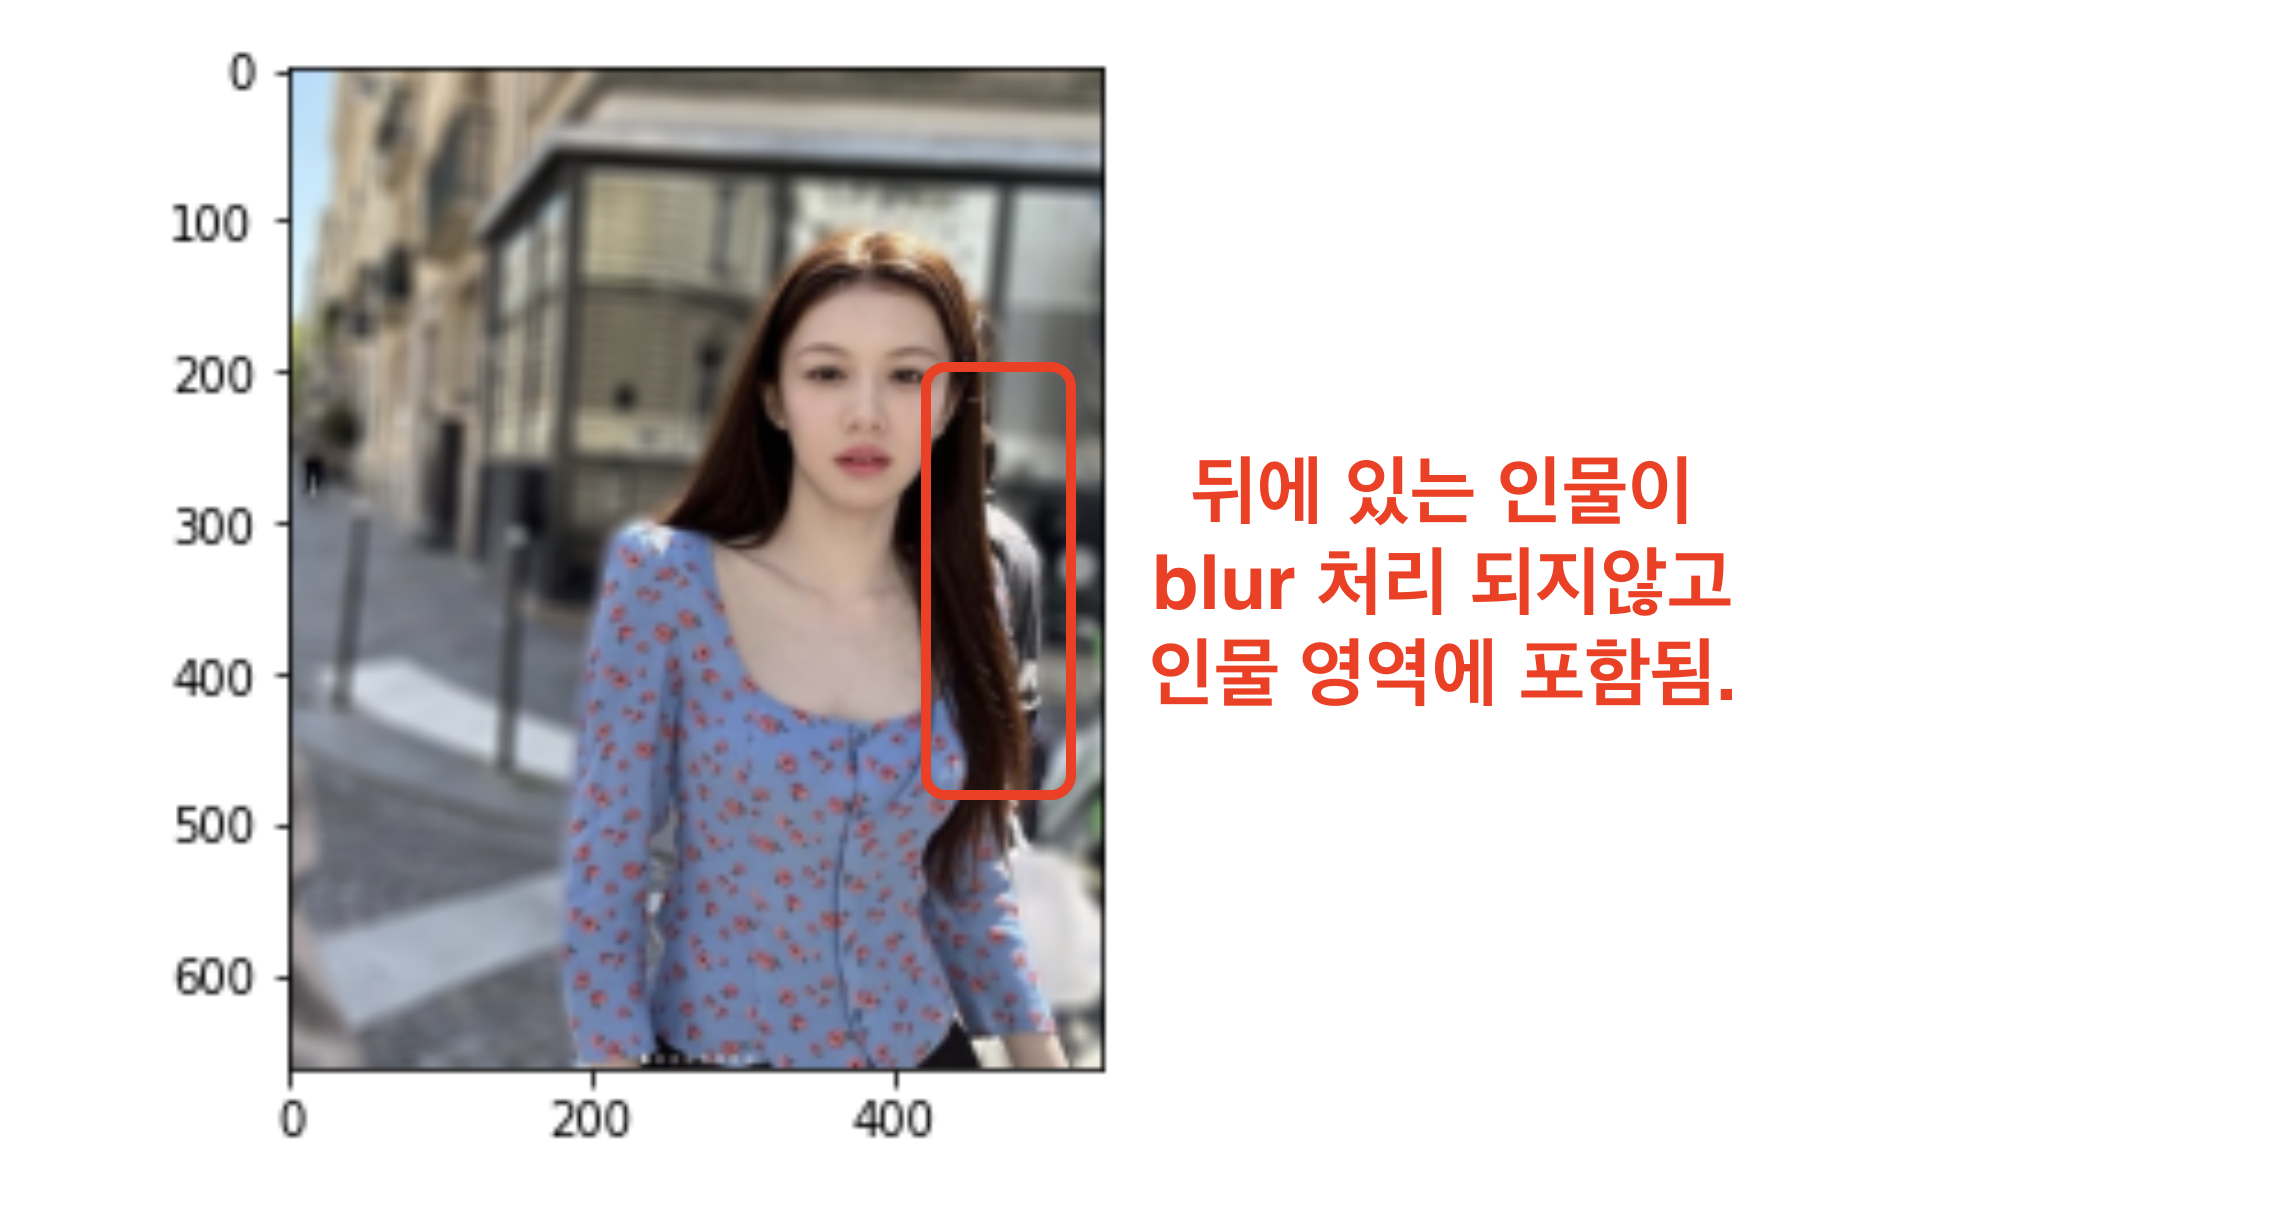

In [51]:
from IPython.display import Image

# 인물사진 1번째
Image("problem_1.png")

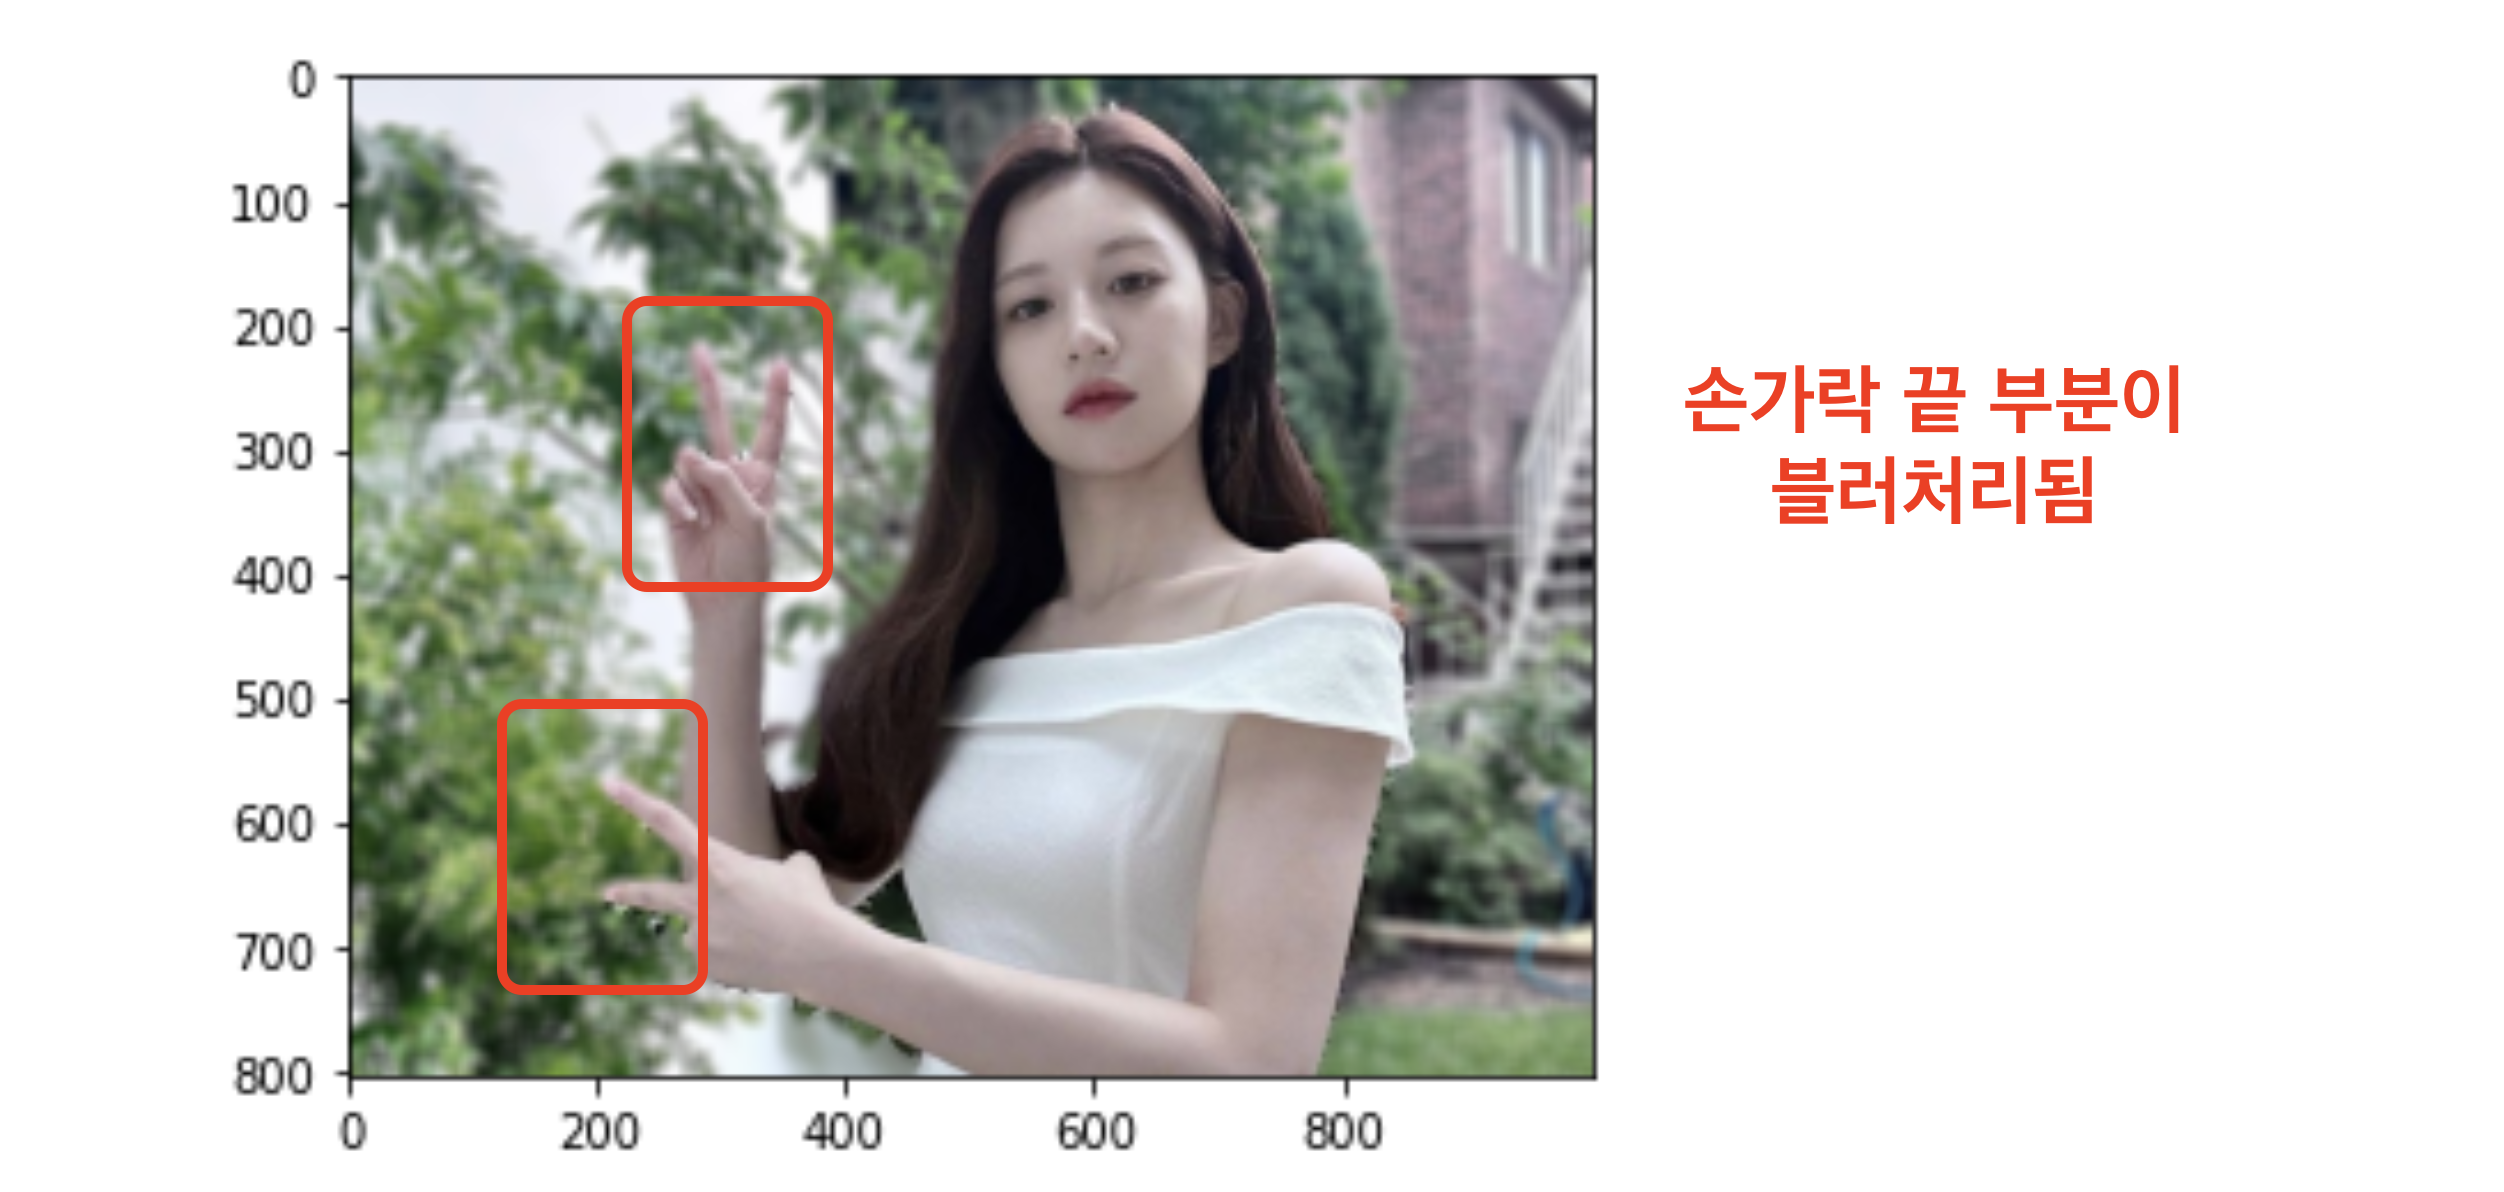

In [52]:
# 인물사진 2번째
Image("problem_2.png")

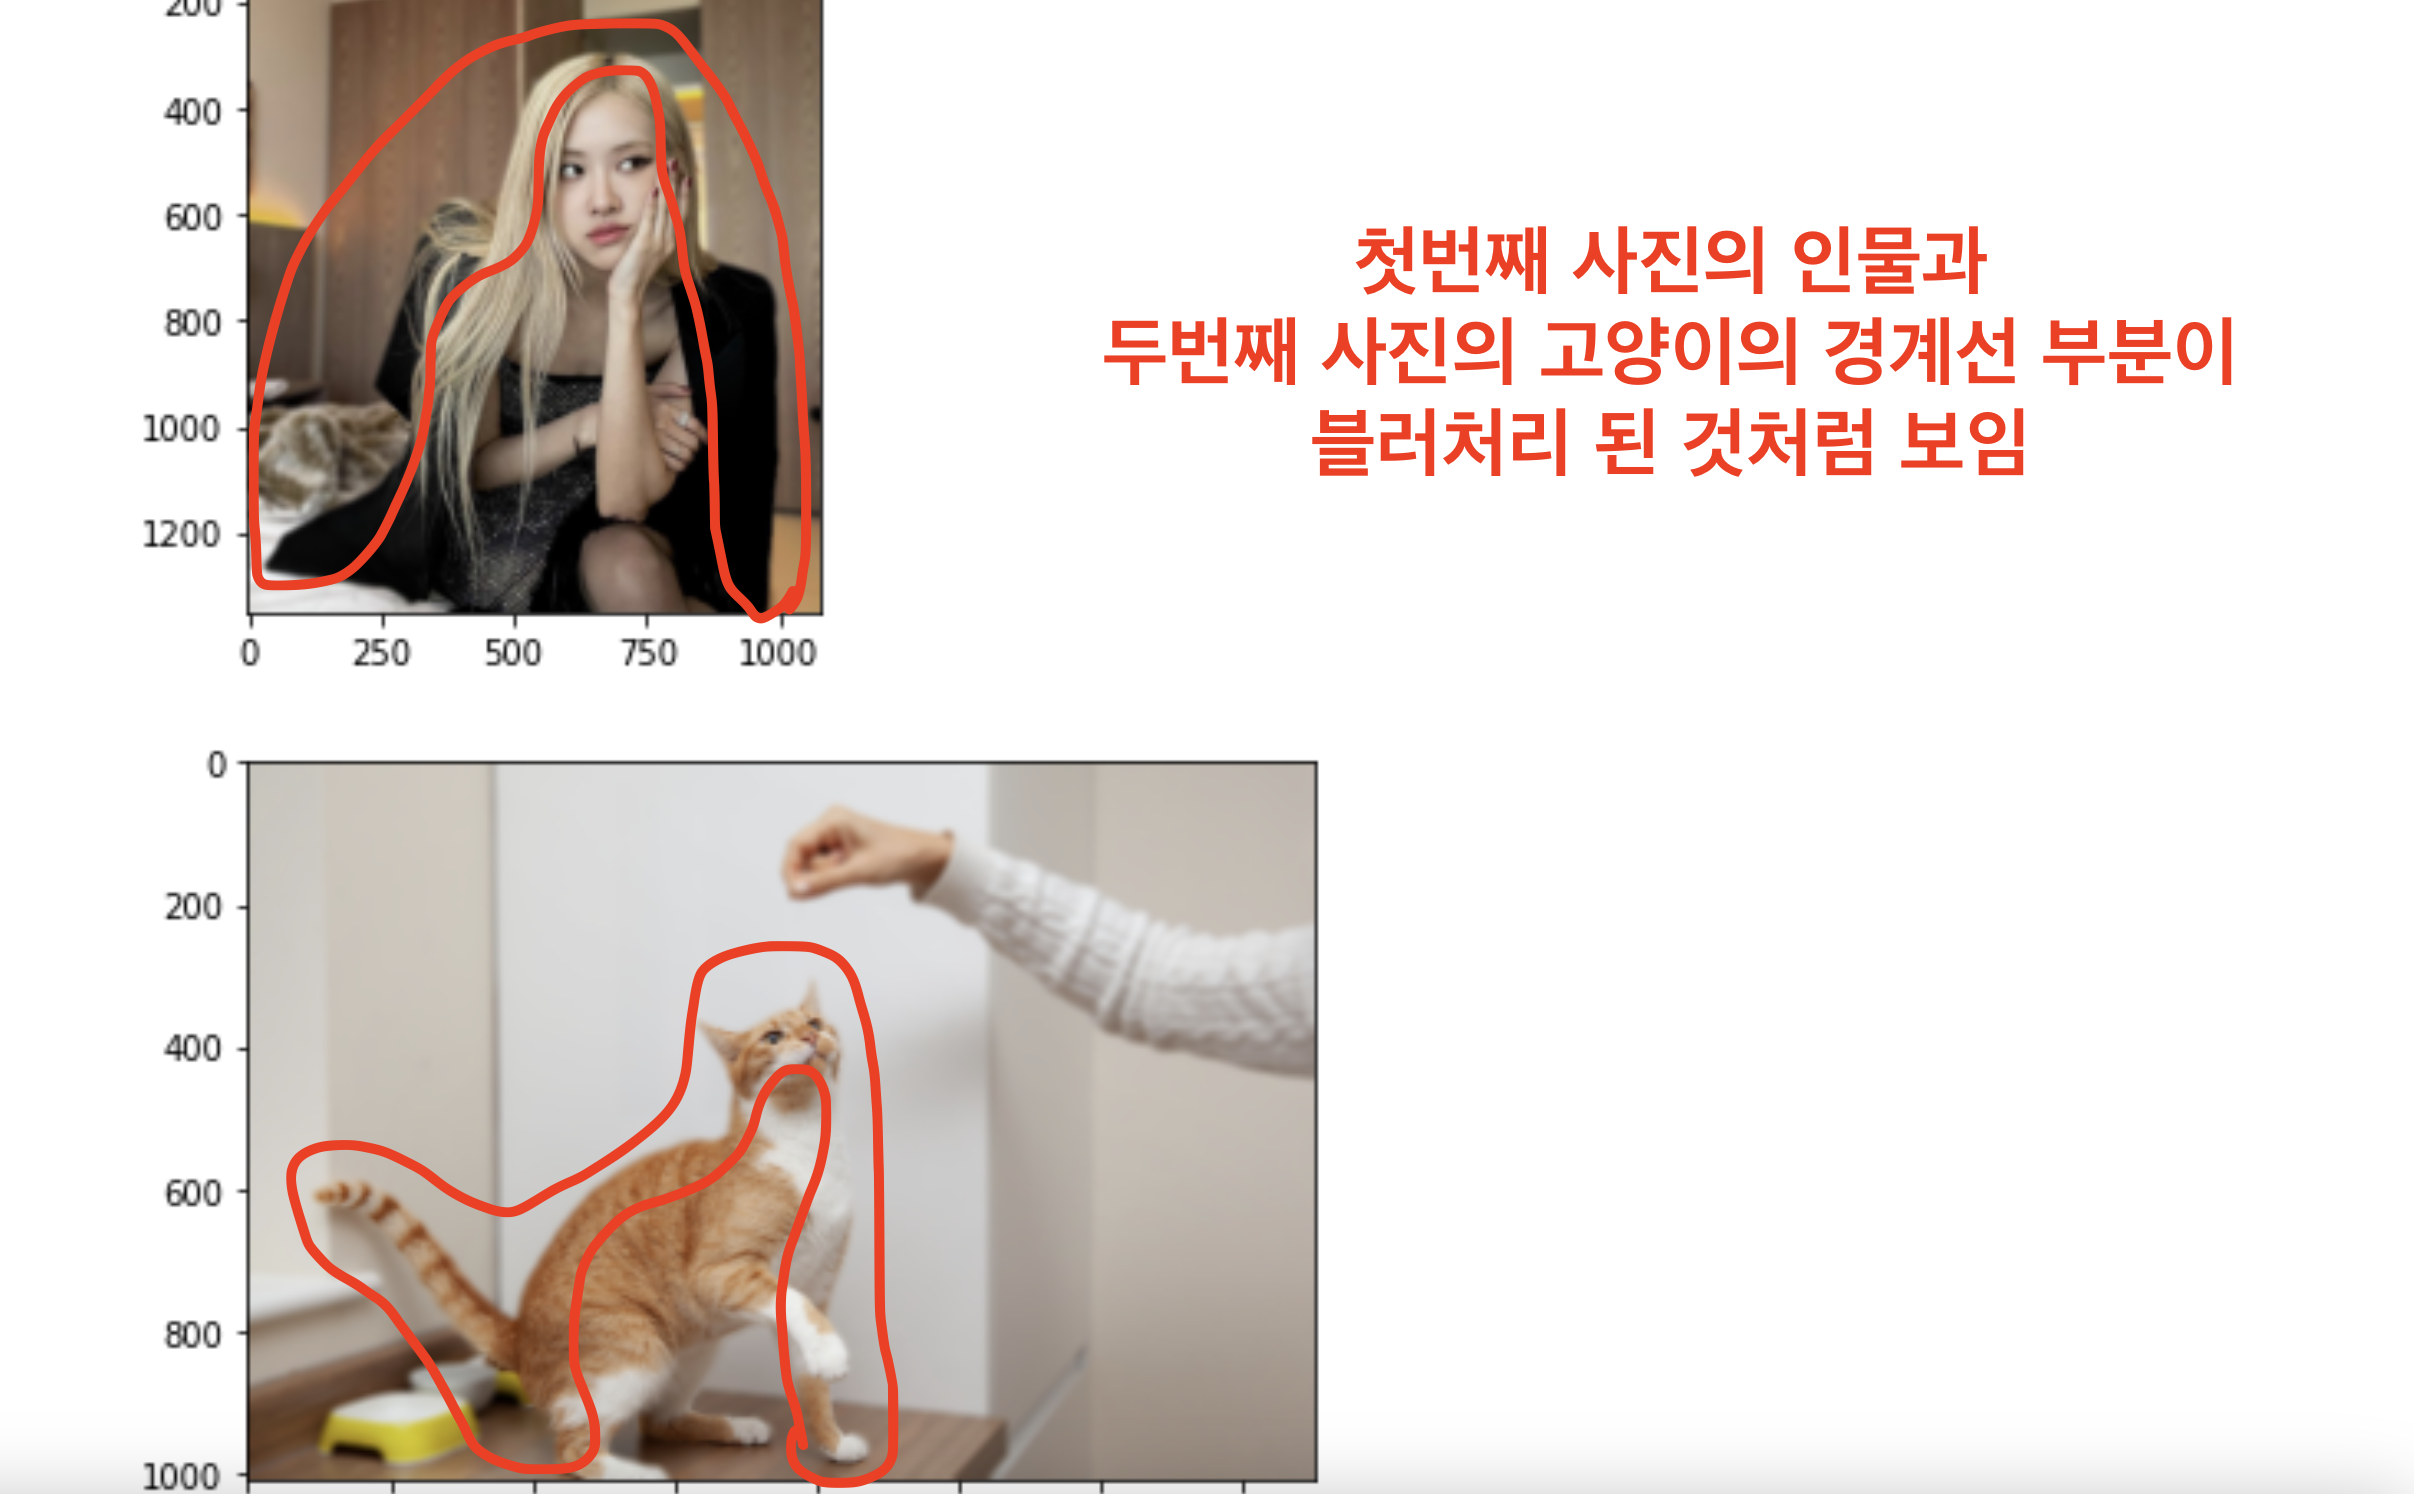

In [53]:
# 인물사진 3번째, 고양이 사진
Image("problem_3.png")

## 4. 해결 방법을 제안해 보기
아주 간단히 멋진 카메라 앱 서비스를 만들어 출시할 수 있을 것 같았지만, 지금 같은 완성도로는 어림도 없습니다.   
소비자들의 눈높이는 그리 호락호락하지 않고, 엔지니어인 여러분들은 답을 찾아내야 합니다.  

생각해 볼 만한 주제를 아래에 몇 가지 제시해 봅니다.   
아래를 읽어본 후, 여러분이 만든 인물모드 사진의 문제점을 해결할 방안을 정리하여 제안해 주시기 바랍니다.  
단순히 'XXX 기술을 사용한다.' 정도의 선언적 솔루션이 아니라,   
여러분들이 선택한 기술이 DeepLab 모델의 Semantic Segmentation 이 만들어 낸 Mask 영역에   
어떻게 적용되어 문제점을 보완하게 되는지의 메커니즘이 포함된 솔루션이어야 합니다.  

#### 세그멘테이션의 한계
Semantic segmentation의 부정확성이 여러 가지 문제를 발생시키는 주요 원인입니다.   
피사계심도를 이용한 보케(아웃포커싱) 효과는 말 그대로 심도를 표현하기 때문에 초점이 잡힌 거리를 광학적으로 아주 섬세하게 구별(segmentation) 하지만  
이를 따라 한 semantic segmentation 모듈은 정확도가 1.00 이 되지 않는 한 완벽히 구현하기는 힘듭니다.  

#### 피사계 심도 이해하기
우선 피사계심도의 개념부터 명확히 이해해 봅시다.
- [아웃포커싱 하는 법](https://m.blog.naver.com/typs6301/222172333739)
- [얕은 피사계 심도 촬영의 이해](https://www.adobe.com/kr/creativecloud/photography/discover/shallow-depth-of-field.html)

#### 3D Camera 활용하기
이미지를 2D 방식으로 받아들이는 한계를 넘어 3D로 인식하려는 시도는 꽤 오래전부터 계속되어 왔습니다.   
기술도 이제는 상당한 수준에 이르렀는데요. 크게는 스테레오 비전, ToF 방식 등이 자주 사용됩니다.   
하드웨어 이미지 센서를 통한 3D 이미징 기술이 많이 발전되었는데요. 아래 참고 자료를 통해 최신 기술을 살펴봐도 좋습니다.

- [3D 이미지센서](https://news.skhynix.co.kr/post/next-gen-3d)

#### 소프트웨어 기술 활용하기
하드웨어 개발과 생산에는 비용이 많이 들기 때문에 제한된 하드웨어를 이용하면서 소프트웨어로 그 한계를 극복하려는 노력도 많습니다. 구글의 struct2Depth가 대표적인 예일 것 같습니다.

- [Unsupervised Learning of Depth and Ego-Motion: A Structured Approach](https://sites.google.com/view/struct2depth)
![이미지](https://d3s0tskafalll9.cloudfront.net/media/images/E-14-14.max-800x600.png)

딥러닝이 발전한 지금은 더 다양한 기술이 개발되어 있으니 잘 탐색해 보세요.

다른 기술과 융합해 보기
구글 pixel4에는 IR(적외선) 카메라가 달려있습니다.   
물체의 온도를 측정하는 IR 카메라와 3D 이미지는 크게 관련이 없을 것 같지만, 이를 통해 보다 멋진 3d depth sensing이 가능하다는군요.  

- [uDepth: Real-time 3D Depth Sensing on the Pixel 4  ](https://blog.research.google/2020/04/udepth-real-time-3d-depth-sensing-on.html)  

이렇게 카메라와 무관한 다른 기술과 융합하는 것도 좋은 해결책이 될 수 있습니다. 한 번 고민해 보세요!  

이 외에도 다른 방식으로 접근해도 좋습니다.   
엔지니어로서 본인이 선택한 솔루션을 잘 설명해 주세요. 가능하다면 순서도(Flow Chart)를 활용하면 좋습니다. 멋진 아이디어를 기대하겠습니다!!

#### [개념 정리_블로그 참조] 피사계심도와 아웃포커스의 관계
1. 카메라 이미지 센서 : 센서가 크면 심도가 얕은 사진(아웃포커스), 센서가 작으면 피사계 심도가 깊은 사진(팬포커스)을 찍는 데 유리하다.
2. 망원렌즈를 사용하거나 줌을 했을 때 : 
    - 망원렌즈를 쓰면 아웃포커싱이 더 잘 되고, 광각렌즈를 쓰면 그 반대이다. 
    - 모든 설정을 같게 한다면 줌렌즈에서는 줌을 당겼을 때 아웃포커싱이 더 잘된다.
3. 조리개가 많이 개방될수록 (F값이 작을수록) 심도가 얕아진다. (아웃포커스가 잘 된다.)
4. 카메라와 피사체간의 거리가 가까울수록 심도가 얕아진다.
5. 피사체와 배경과의 거리가 멀수록 심도가 얕아진다.

### 문제점
- 객체와 배경의 경계가 뚜렷하지 않아 객체의 영역에 배경이 포함되거나 배경의 영역에 객체가 포함되는 문제가 발생하였다.

### 아이디어
- 데이터 측면 : 품질이 좋은 데이터를 사용합니다. 아래는 품질 확인 방법입니다.
    - 데이터의 픽셀값이 정상 범위인가?
    - 데이터에 노이즈가 많은가?
        - 센서 노이즈: 카메라의 센서에서 발생하는 노이즈입니다. 센서의 열, 전기적 노이즈, 주변 환경의 간섭 등이 원인이 될 수 있습니다.
        - 환경 노이즈: 이미지를 촬영할 때의 환경에서 발생하는 노이즈입니다. 조명 불량, 먼지, 떨림 등이 원인이 될 수 있습니다.
        - 압축 노이즈: 이미지를 압축할 때 발생하는 노이즈입니다. 이미지의 데이터를 줄이기 위해 압축 알고리즘을 사용하는데, 이 과정에서 원본 이미지의 정보가 일부 손실되어 노이즈가 발생할 수 있습니다.
    - 데이터에 잘못된 레이블이 있는가?
- 인코더 측면 : 경계(엣지)를 더 잘 학습하도록 하면 어떨까?(pooling 시 더 자세히 살피기, 층을 더 깊게 만들기 등) 혹은 그런 다른 모델을 활용해보면 어떨까?
- 디코더 측면 : 각 물체에 해당하는 boundary를 더 정교하게 그리려면 어떻게 해야할까?

### 해결방안
- 데이터 측면 : 해상도가 좋은 이미지 데이터를 사용하기.
- 인코더 측면
    - ASPP : 더 다양한 receptive field를 볼 수 있도록 더 다양한 확장비율 (dilation rate, r)을 가진 atrous convolution을 추가한다.
- 그 외 : Instance Segmentation을 활용한다.

---
## 회고

### KEEP
- 오류를 해결하기 위해 여러가지 코드 구글링, 기존에 학습한 코드 활용 등 다양한 시도를 하였다.
- 크로마키 오류 해결에 너무 많은 에너지를 써서 힘들었지만 끝까지 포기하지 않고 성공시켰다.

### PROBLEM
- 크로마키 시 커널이 죽는 문제 및 오류가 발생. (구글링해서 얻은 코드들을 실행할 때)   
    - 광석 퍼실님께 질문하여 초록색으로만 가득찬 이미지를 만들어서 고양이 이미지와 합치기, 행렬의 축 연산을 활용하여 코드 2줄이면 해결 가능하다는 가이드를 받음.  
    - 그러나 행렬의 축 연산을 활용하는 것이 어떻게 적용해야할지 잘 모르겠다.  
- mask 문제점 해결방안 찾기  
    - 노드에서 제공된 여러 개념들이 또 다른 전문 분야라 이해하기 어렵다.

### TRY
- [크로마키] 행렬의 축 연산을 활용하는 것 : 지금 프로젝트에 매몰되지 않은(?) 상태일 때 (저녁이나 주말에) 다시 보고 적용해봐야겠다.
- [mask 문제점] 해결 방안 : 여러 분야를 접목시켜서 문제를 해결하는 넓은 시야를 갖고, 평소에 관심있는 분야를 꾸준히 탐색해봐야겠다.

## Reference
- [크로마키](https://medium.com/fnplus/blue-or-green-screen-effect-with-open-cv-chroma-keying-94d4a6ab2743)
- [크로마키2](https://github.com/tejakummarikuntla/blue-screen-effect-OpenCV/blob/master/blue-screen-effect.ipynb)
- [크로마키3-커널 죽는 문제 발생](https://www.geeksforgeeks.org/replace-green-screen-using-opencv-python/)
- [크로마키4](https://blog.naver.com/PostView.nhn?blogId=teach3450&logNo=221934940858&parentCategoryNo=&categoryNo=25&viewDate=&isShowPopularPosts=true&from=search)
- [atrous convolution, receptive field](https://wikidocs.net/147019)
- [DeepLab V3+](https://wikidocs.net/143446)

---

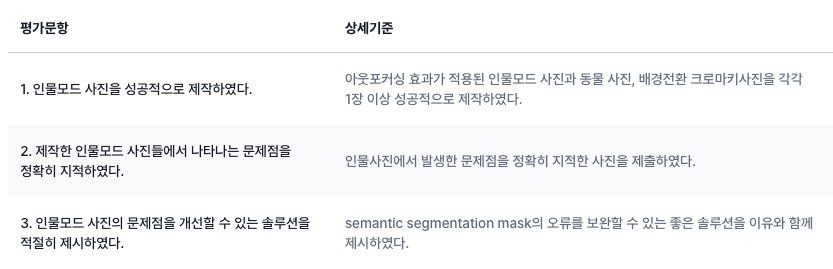

In [2]:
# 루브릭

from IPython.display import Image
Image("rubric.png")